# Installs

In [1]:
import torch;
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.1.0+cu118
11.8
True


In [2]:
!pip install pytorch-lightning
!pip install torch-geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install jax
!pip install jaxlib==0.4.14+cuda11.cudnn86 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install tensorcircuit
!pip install qiskit
!pip install matplotlib
!pip install pylatexenc
!pip install tabulate
!pip install kmapper
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 57.8 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.1/191.1 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.20+cuda11.cudnn86
    Uninstalling jaxlib-0.4.20

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [69]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

0.11.0


In [6]:
jax.devices()

[gpu(id=0)]

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


# VQC

In [8]:
def get_circ(nqubits, nlayers, x, weights):
    # print(x.shape, x.val, x[1])
    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

# test = None;

def circuit_wrapper(nqubits, nlayers):
    # global test
    # We define the quantum function,
    # note how this function is running on jax
    def qpred(x, weights):
        # global test
        # print(x.shape, "In wrapper", x)
        circuit = get_circ(nqubits, nlayers, x, weights)
        # print(circuit)
        # test = circuit
        # print(K.real(jnp.array(circuit.expectation_ps(z=[1]))))
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    # `qpred_vmap` is a jax function with vectorization capacity
    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)

    # Wrap the function into pytorch form but with jax speed!
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

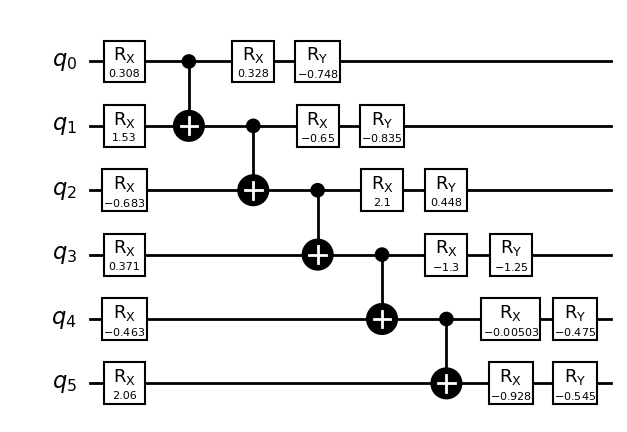

In [9]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 1
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig.savefig('Quantum_circ.pdf', format='pdf', dpi=300, bbox_inches='tight');
fig

In [10]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [11]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[ 0.3084,  1.5312, -0.6826,  0.3715, -0.4635,  2.0592],
        [-0.4124,  0.7590, -0.8194,  0.4814,  0.6586,  0.9199],
        [ 2.2039,  0.5810,  0.0292, -0.1117, -0.5737, -0.4898]])
tensor([[-3.0143e-01,  8.4441e-02,  8.7389e-03, -1.8820e-02, -3.1356e-04,
         -3.6526e-01],
        [ 8.2239e-01,  1.2270e-01, -2.4751e-03, -1.5909e-02, -3.2044e-02,
          1.3780e-01]]) tensor([[ 0.6614,  0.0202, -0.0134,  0.0023,  0.0217,  0.0089],
        [ 0.6360,  0.3554, -0.2078,  0.0346,  0.2829,  0.2719],
        [-0.4107, -0.2644,  0.2264, -0.0423, -0.3669, -0.0537]],
       grad_fn=<FunBackward>)


In [12]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [13]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[-0.3675,  0.1054,  0.2546, -0.1037,  0.0602,  0.0973],
        [-0.2695,  0.1645,  0.1678, -0.1669, -0.1607,  0.0222],
        [-0.4342,  0.4336, -0.0451, -0.0595,  0.1455, -0.3685]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [14]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 1,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

In [15]:
gnn_layer_by_name = {
    "QGCN": QGCNConv,
    "GCN" : geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv,
    "SAGE": geom_nn.SAGEConv
}

# Finance Dataset

In [16]:
data_path = "/content/drive/MyDrive/QIntern/creditcard.csv"

In [17]:
finance_df = pd.read_csv(data_path)

In [18]:
finance_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
finance_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [20]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

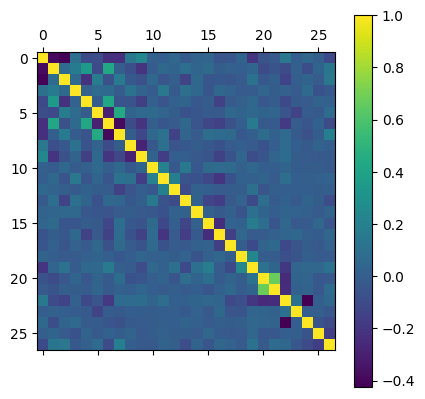

In [21]:
view_cov = finance_df[finance_df.columns[1:28]].corr(method = 'spearman');
#  'pearson', 'spearman', 'kendall',
plt.matshow(view_cov);
plt.colorbar()
# print(view_cov)
plt.savefig('Data_corr.pdf', format='pdf', dpi=300, bbox_inches='tight');

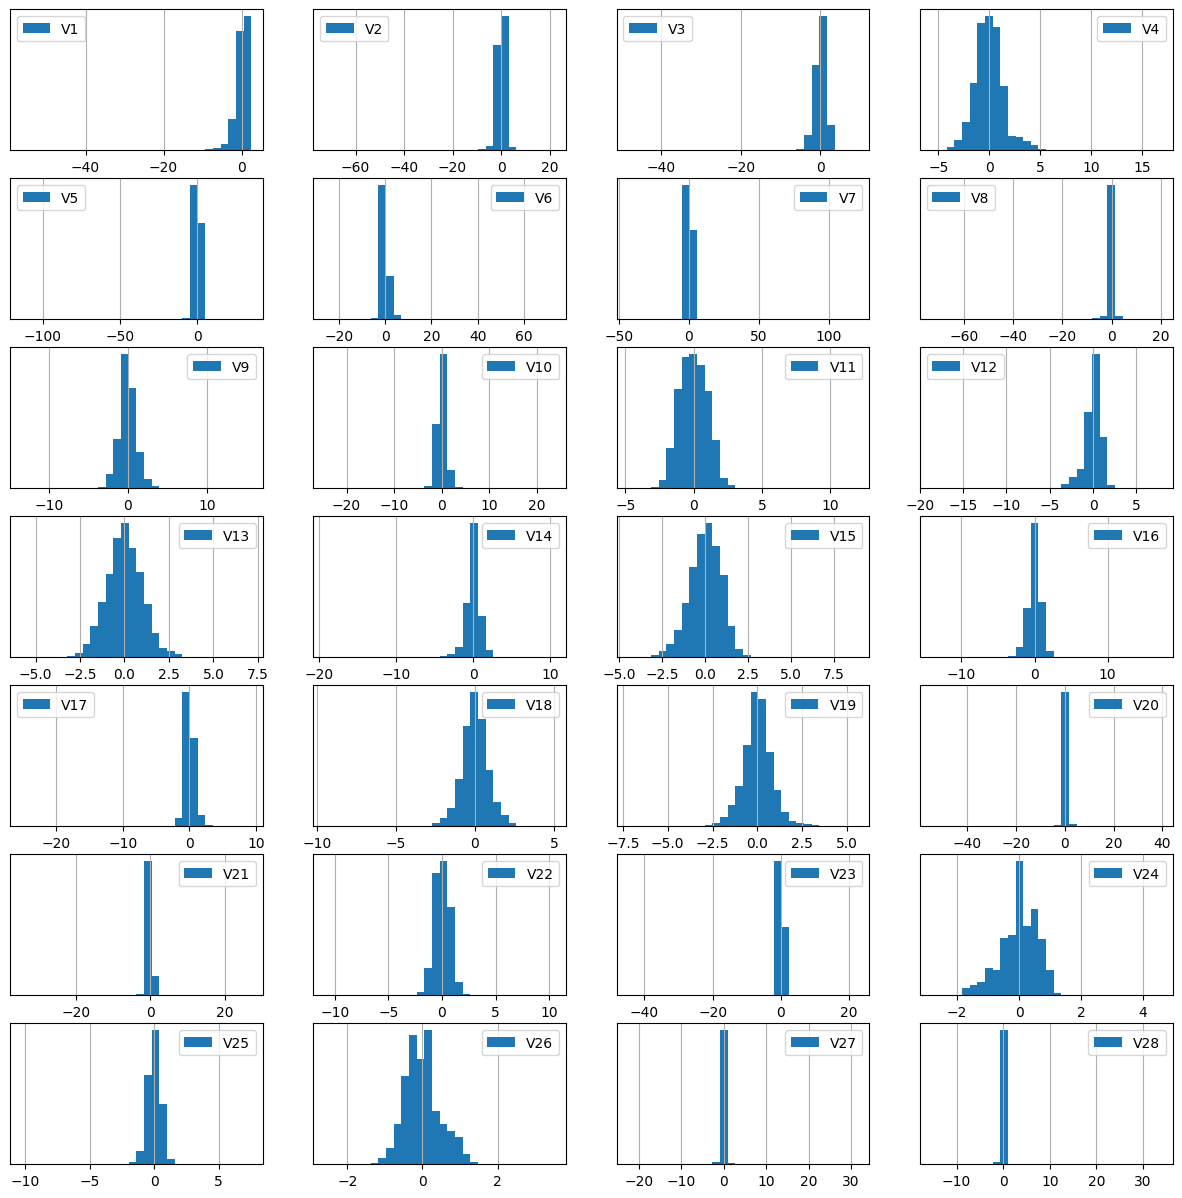

In [22]:
fig, axs = plt.subplots(7, 4, figsize=(15,15))
for n, col in enumerate(finance_df.columns[1:29]):
    axis = axs[n//4 , n % 4];
    axis.axes.get_yaxis().set_visible(False)
    finance_df[col].hist(ax=axis,legend=True, bins = 30)
# plt.show();
fig.savefig('Data_dist.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [23]:
def get_graph(nx_graph, data, row):
  nodes = list(nx_graph.nodes());
  edges = list(nx_graph.edges());
  feature = [];
  for n in nodes:
    mem = np.array(nx_graph._node[n]['membership']);
    id = np.zeros(28, dtype = int);
    id[mem] = 1;
    ft = data * id;
    feature.append(ft)
  edges = np.array(list(map(lambda x: (nodes.index(x[0]), nodes.index(x[1])),edges)))
  nodes = np.array(list(map(lambda x: nodes.index(x),nodes)))
  return nodes, edges.transpose(), np.array(feature);

In [24]:
fraud_id = finance_df.Class[finance_df.Class.eq(1)].index
nofraud_id = finance_df.Class[finance_df.Class.eq(0)].sample(len(fraud_id)*3).index

df_reduced = finance_df.loc[fraud_id.union(nofraud_id)].sample(frac = 1).reset_index( drop = True);

In [25]:
print(fraud_id.shape, nofraud_id.shape)

(492,) (1476,)


In [26]:
df_reduced.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127865.0,-1.526014,-1.615329,0.529372,-2.197003,-0.007290,-0.242477,-1.472880,0.625009,-2.203829,...,0.022737,-0.001439,-0.291025,0.185465,-0.157298,-0.124179,-0.102343,-0.010830,16.20,0
1,14450.0,-0.342579,0.605337,1.431034,-0.187368,0.240869,0.862793,-0.178062,0.251202,1.074925,...,0.045188,0.345093,-0.236804,-1.152134,-0.606803,1.179422,-0.060148,0.095338,12.95,0
2,111107.0,2.103330,-0.004436,-1.448710,0.332912,0.307490,-0.743324,-0.010635,-0.292549,2.228408,...,0.082396,0.578968,0.004318,0.404920,0.328264,-0.471566,-0.030937,-0.058603,1.00,0
3,127776.0,1.682030,-0.343876,-2.065525,1.069003,1.241435,0.943406,0.473941,0.124736,-0.057004,...,0.208638,0.633634,-0.121648,-1.615901,0.274027,-0.393660,0.005748,-0.067772,127.53,0
4,158773.0,-0.466258,0.832029,-0.428069,-0.951695,1.059196,0.935128,0.294579,0.832035,-0.432345,...,-0.119473,-0.255673,0.133224,-1.640321,-0.624199,0.254224,0.165504,-0.000092,9.99,0


In [27]:
df_reduced.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,...,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000
mean,92342.663618,-1.202024,0.922658,-1.772537,1.110517,-0.752929,-0.356126,-1.343486,0.158882,-0.643284,...,0.160007,0.001567,0.000211,-0.031308,0.003843,0.004674,0.025366,0.016156,96.006804,0.250000
std,47926.671997,4.301402,2.995558,4.840937,2.727309,3.234275,1.583963,4.478487,3.507080,1.929201,...,2.023564,0.974369,0.982662,0.589013,0.613576,0.481671,0.789494,0.381036,279.523074,0.433123
min,34.000000,-30.552380,-23.250844,-31.103685,-4.759357,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.822684,-4.781606,-1.521585,-7.263482,-2.733887,0.000000,0.000000
25%,51665.500000,-1.520009,-0.403498,-2.067876,-0.573008,-1.031271,-1.063240,-1.094545,-0.216052,-1.270129,...,-0.206480,-0.550799,-0.192188,-0.378863,-0.317681,-0.314725,-0.072962,-0.052295,3.397500,0.000000
50%,84204.000000,-0.409616,0.416015,-0.373200,0.394310,-0.165436,-0.468406,-0.124453,0.078645,-0.307598,...,0.028682,0.020468,-0.024966,0.012749,0.016636,-0.040976,0.021276,0.020498,20.735000,0.000000
75%,139109.500000,1.195662,1.339783,0.742920,1.994544,0.643365,0.177504,0.491891,0.539838,0.437471,...,0.330458,0.556809,0.160356,0.388134,0.368567,0.283030,0.219101,0.129478,89.962500,0.250000
max,172574.000000,2.352338,22.057729,3.292151,12.114672,11.095089,9.444569,21.246173,20.007208,6.318419,...,27.202839,8.361985,17.297845,1.251195,2.609676,2.745261,3.052358,5.804307,6950.510000,1.000000


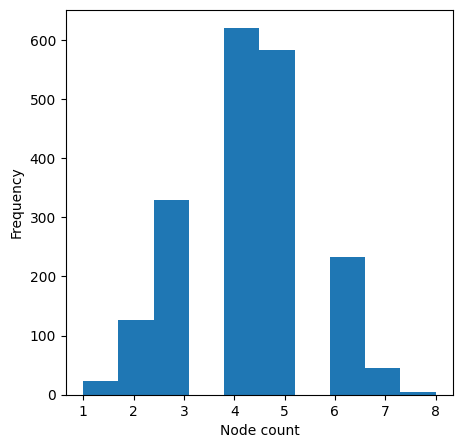

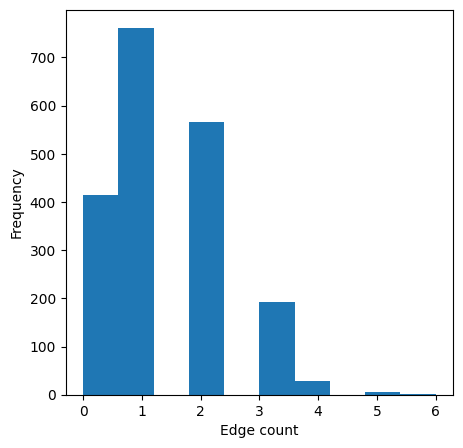

In [154]:
mp = km.KeplerMapper()
transform = T.Compose([T.Pad(max_num_nodes = 16,
                             max_num_edges = 5, mask_pad_value=True)])

def get_data(df):
  data_list = [];
  count = 1;
  nodes_dist, edges_dist = [], [];
  graphs = [];
  for i in range(df.shape[0]):
    data_row = df.loc[i,df.columns[1:29]].to_numpy()
    # print(data.shape)
    data = data_row.transpose()

    Y = df.iloc[i,30]

    amt = df.iloc[i,29]
    time = df.iloc[i,0]
    amt = np.repeat(amt,data.shape[0])
    time = np.repeat(time,data.shape[0])

    data = np.stack((data,amt,time), axis = 1)

    lens = mp.project(data)
    # projected_data = mp.fit_transform(data, projection=[0,1]) # X-Y axis

    # print(lens.shape, data.shape, projected_data.shape)
    # print(data, lens, projected_data)
    # print("index", i)

    cover = km.Cover(n_cubes=10)

    graph = mp.map(X=data, lens=lens,
                  #  cover = cover,
                  #  clusterer=skl.cluster.DBSCAN(metric="cosine")
                    )
    nx_graph = km.adapter.to_nx(graph)

    # html = mp.visualize(graph)
    # break;

    nodes, edges, features = get_graph(nx_graph, data_row, i);
    # print(nodes, edges, features, len(edges));
    # break;

    nodes_dist.append(len(nodes));
    edges_dist.append(0 if len(edges) == 0 else edges.shape[1]);

    # if len(edges)> 0 and edges.shape[1] == count:
    #   nx.draw(nx_graph,label = True)
    #   plt.show()
    #   print("row: ", i , "value: " ,vars(nx_graph), features)
    #   count += 1;
    # break;

    data_list.append(
        # transform(
        geom_data.Data(x=torch.tensor(features, dtype = torch.float),
                                    edge_index = torch.tensor(edges, dtype = torch.int64),
                                    y = torch.tensor(Y))
        # )
    )
    graphs.append((nx_graph, nodes, edges, features));

  fig = plt.figure(figsize=(5,5))
  plt.hist(nodes_dist, label = "nodes_dist");
  plt.xlabel("Node count");
  plt.ylabel("Frequency")
  plt.show();
  fig.savefig(f'Node_dist.pdf', format='pdf', dpi=300, bbox_inches='tight');
  fig = plt.figure(figsize=(5,5))
  plt.hist(edges_dist, label = "edge_dist");
  plt.xlabel("Edge count");
  plt.ylabel("Frequency")
  plt.show();
  fig.savefig(f'Edge_dist.pdf', format='pdf', dpi=300, bbox_inches='tight');
  return data_list, graphs;

data_list, graphs = get_data(df_reduced);

In [29]:
batch_s = 32;
split = int(len(data_list) * 0.75);
graph_train_loader = geom_data.DataLoader(data_list[:split], batch_size=batch_s,shuffle=True)
graph_val_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)
graph_test_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)

In [30]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y)
print("Batch indices:", batch.batch)
print("Batch ptr:", batch.ptr)

Batch: DataBatch(x=[136, 28], edge_index=[2, 49], y=[32], batch=[136], ptr=[33])
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1])
Batch indices: tensor([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         7,  7,  7,  7,  7,  8,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 16, 16, 16,
        16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19,
        19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 24, 24,
        24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 28, 28, 28, 28,
        29, 29, 29, 29, 29, 30, 30, 30, 30, 31])
Batch ptr: tensor([  0,   4,  10,  15,  22,  27,  32,  36,  41,  42,  45,  50,  54,  57,
         62,  67,  69,  74,  80,  86,  91,  96, 100, 104, 106, 111, 115, 119,
       

#Review 1

In [168]:
print(split)
from joblib import Parallel, delayed
import multiprocessing as mp

cores = mp.cpu_count()

def get_sv(data, qubits):
  fig = plt.figure(figsize=(30,20))

  if qubits == 6:
    axs = fig.subplots(2, qubits//2 ,subplot_kw=dict(projection='3d'))
  elif qubits == 16:
    axs = fig.subplots(4, qubits//4,subplot_kw=dict(projection='3d'))

  B = [];
  for q in range(qubits):
    if qubits == 6:
      ax = axs[q//(qubits//2), q%(qubits//2)]
    elif qubits == 16:
      ax = axs[q//(qubits//4), q%(qubits//4)]
    B.append(Bloch(fig=fig, axes=ax));
    ax.set_title(f"qubit {q+1}")

  layer = nn.Linear(28, qubits)
  nlayers = 1
  w = torch.randn([2 * nlayers, qubits])
  dummy_x = torch.randn([3, qubits])

  def par_add(features, i):
      print(i);
    # if len(edges) > 0 and edges.shape[1] > 1 and len(nodes) >= 3:
      # fig = plt.figure(figsize=(3,3));
      # nx.draw_shell(nx_graph);
      # plt.show();
      # fig.savefig('Graph_sample.pdf', format='pdf', dpi=300, bbox_inches='tight');

      # df = pd.DataFrame(np.matrix(features))
      # df = df.round(2);
      # with pd.option_context('display.max_columns', None, 'expand_frame_repr', False):
        # print (df)
      # fig = plt.figure(figsize = (15,0.5))
      # ax = plt.subplot(111, frame_on=False) # no visible frame
      # ax.xaxis.set_visible(False)  # hide the x axis
      # ax.yaxis.set_visible(False)  # hide the y axis
      # pd.plotting.table(ax, df)  # where df is your data frame
      # plt.show();
      # fig.savefig('Graph_feature.pdf', format='pdf', dpi=300, bbox_inches='tight');

      out = layer(torch.tensor(features, dtype=torch.float))
      # print(out)
      out = out.detach().numpy()
      X, Y, Z = np.empty((0,qubits), float), np.empty((0,qubits), float), np.empty((0,qubits), float)
      for ft in out:
        # print("loop", ft)
        # c = tc.Circuit(qubits)
        # for i in range(qubits):
        #   c.rx(i, theta=ft[i])
        c = get_circ(qubits, nlayers, ft, w)
        e_x =np.array([c.expectation_ps(x=[i]) for i in range(qubits)])[None, :];
        e_y =np.array([c.expectation_ps(y=[i]) for i in range(qubits)])[None, :];
        e_z =np.array([c.expectation_ps(z=[i]) for i in range(qubits)])[None, :];
        # print(X.shape, e_x.shape, type(e_x))
        X = np.append(X, e_x, axis = 0);
        Y = np.append(Y, e_y, axis = 0);
        Z = np.append(Z, e_z, axis = 0);

      # print(e_x.shape, X.shape, X[:,1])
      # fig = plt.figure(figsize=(30,20))
      for q in range(qubits):
        pnt = [X[:,q], Y[:,q], Z[:,q]];
        # if qubits == 6:
        #   # ax = fig.add_subplot(2, qubits//2, q+1, projection='3d')
        # elif qubits == 16:
        #   # ax = fig.add_subplot(4, qubits//4, q+1, projection='3d')
        # b = Bloch(fig=fig, axes=ax)
        # b.add_points(pnt, 'm')
        B[q].add_points(pnt, 'm')
        # b.add_vectors(pnt)
        # b.add_states(pnt)
        # b.render()
        # ax.set_title(f"qubit {q+1}")
        # ax.set_box_aspect([1, 1, 1])
      return True
      # break;

  res = Parallel(n_jobs = cores,
                 backend = 'threading',
                #  return_as = 'generator'
                 )(delayed(par_add)(dt[3], i) for i, dt in enumerate(data))
  # for i, dt in enumerate(data):
  #   if len(dt[2]) > 0 and dt[2].shape[1] > 2 and len(dt[1]) >= 4:
  #     par_add(dt[3], i)
  #     break;
  for q in range(qubits):
    B[q].render()
  plt.show();
  fig.savefig(f'Bloch_rep {qubits}.pdf', format='pdf', dpi=300, bbox_inches='tight');

1476


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


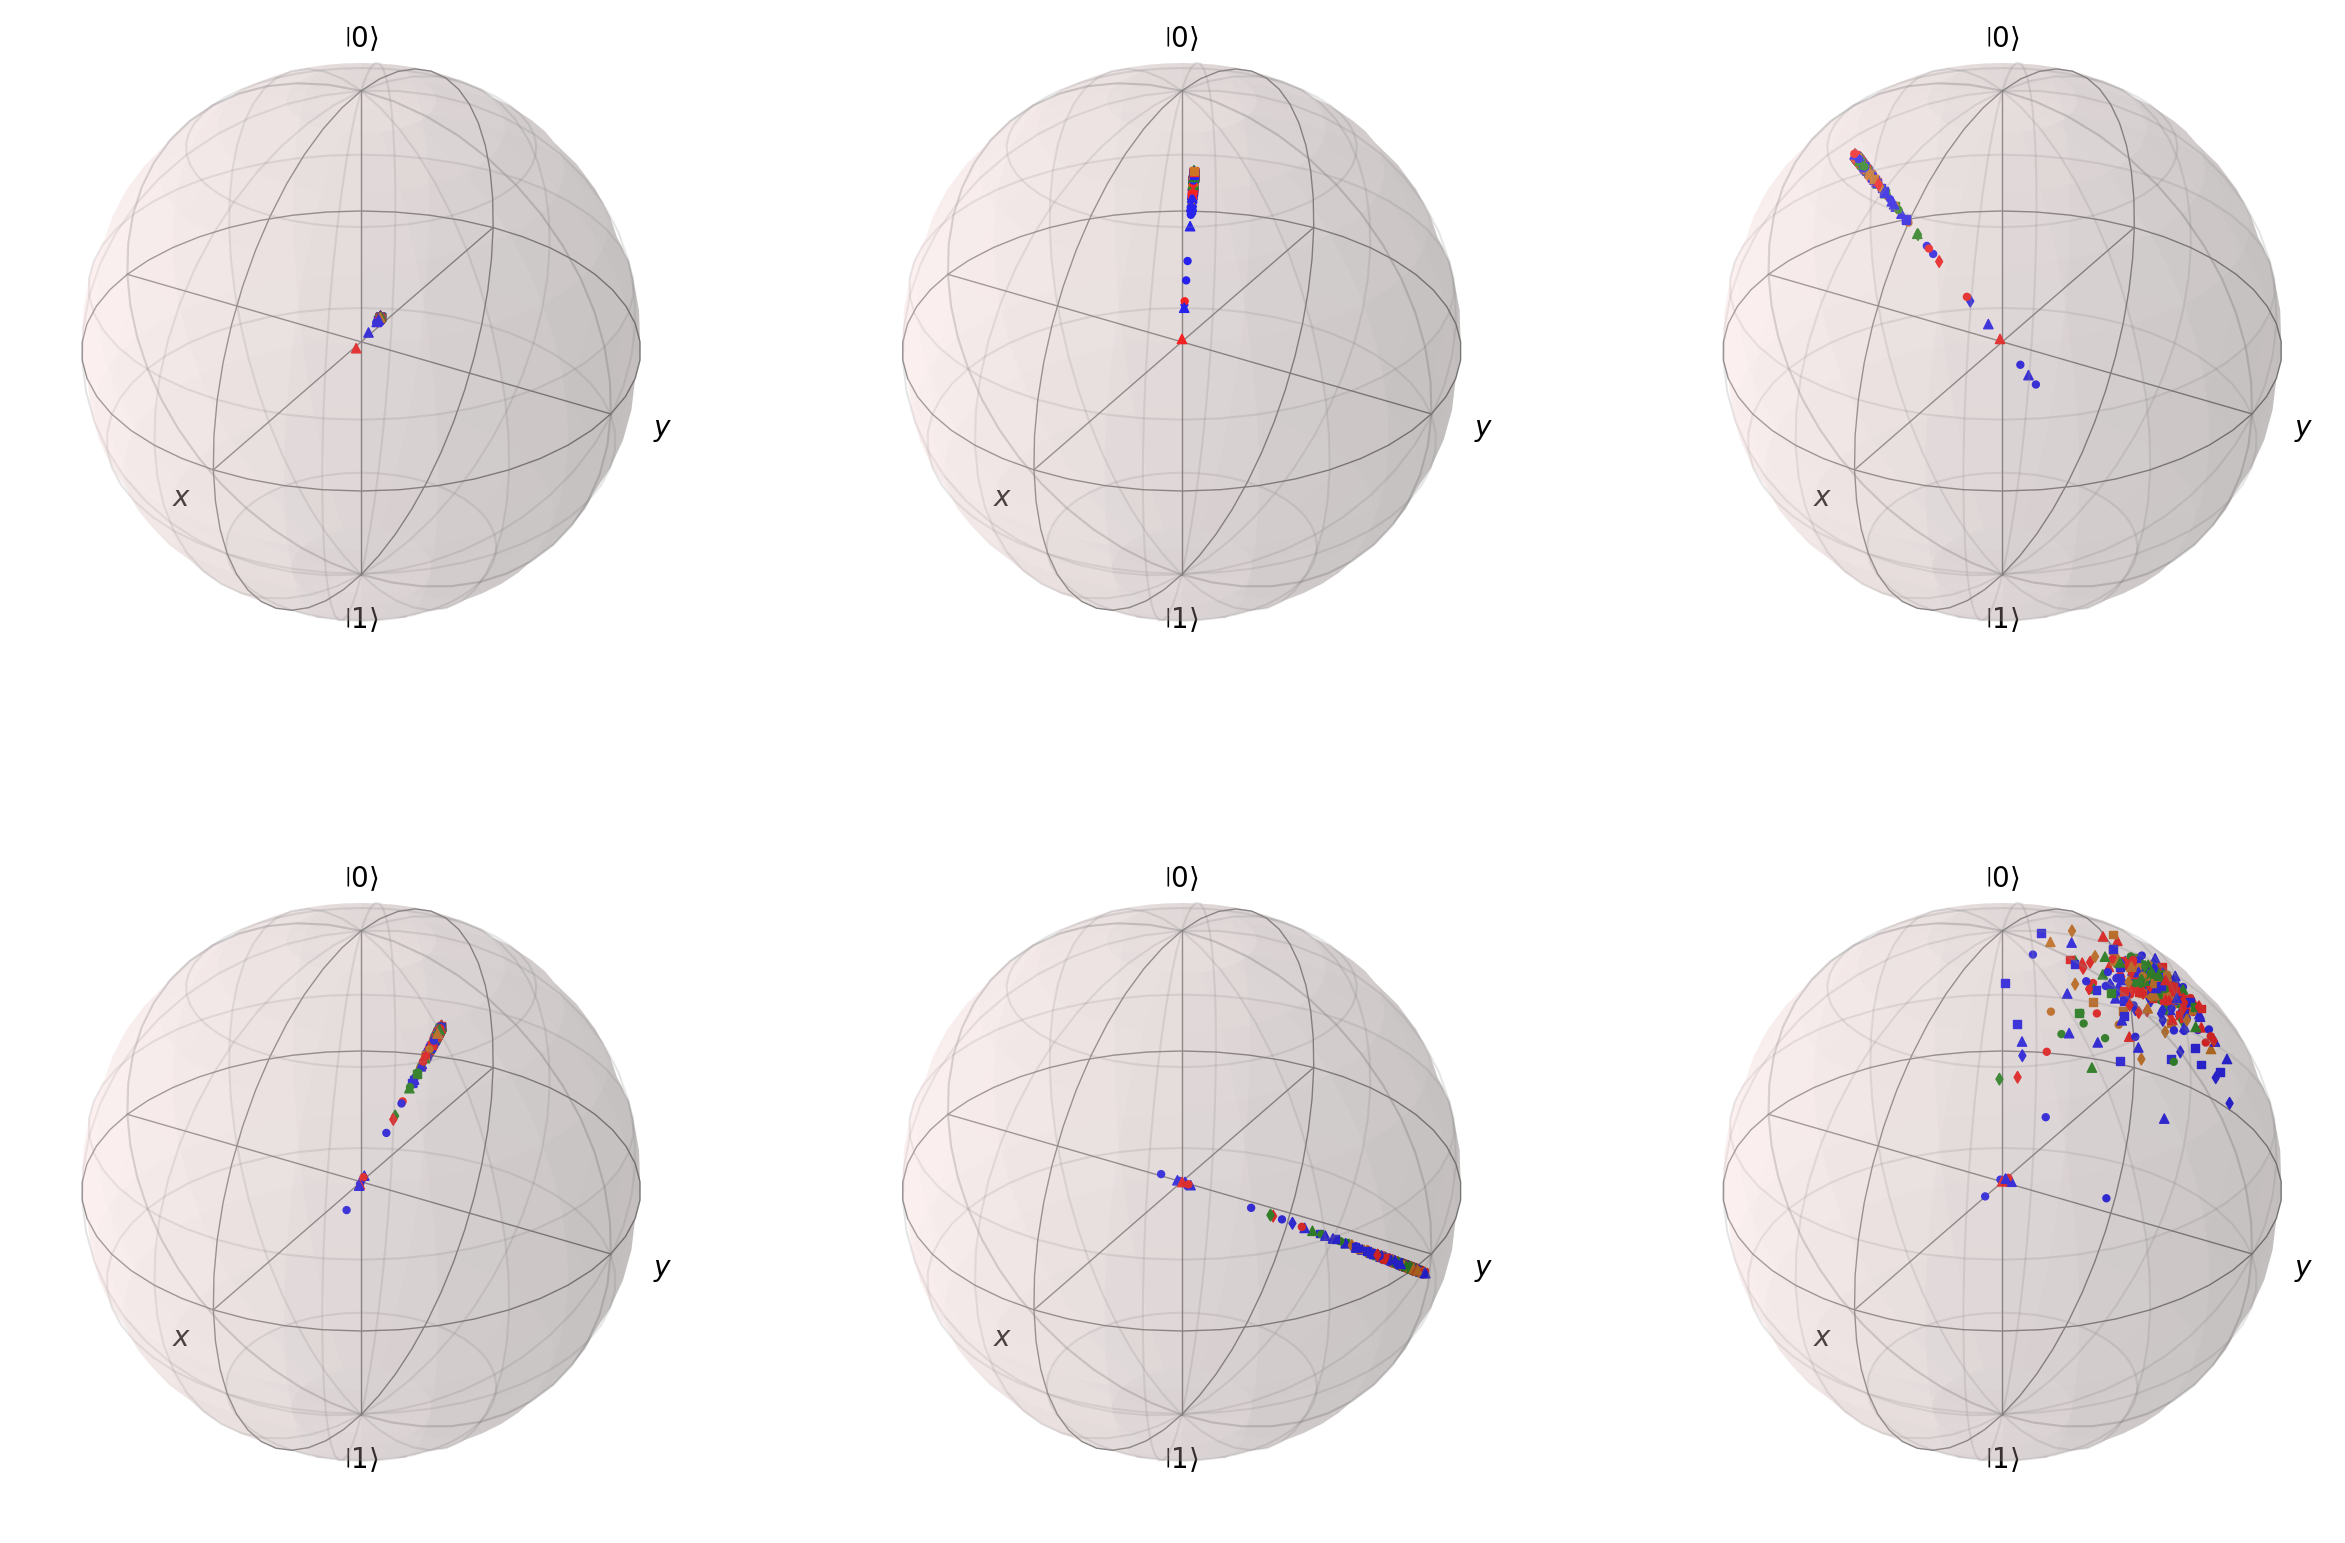

In [166]:
get_sv(graphs[split:split+100], 6)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


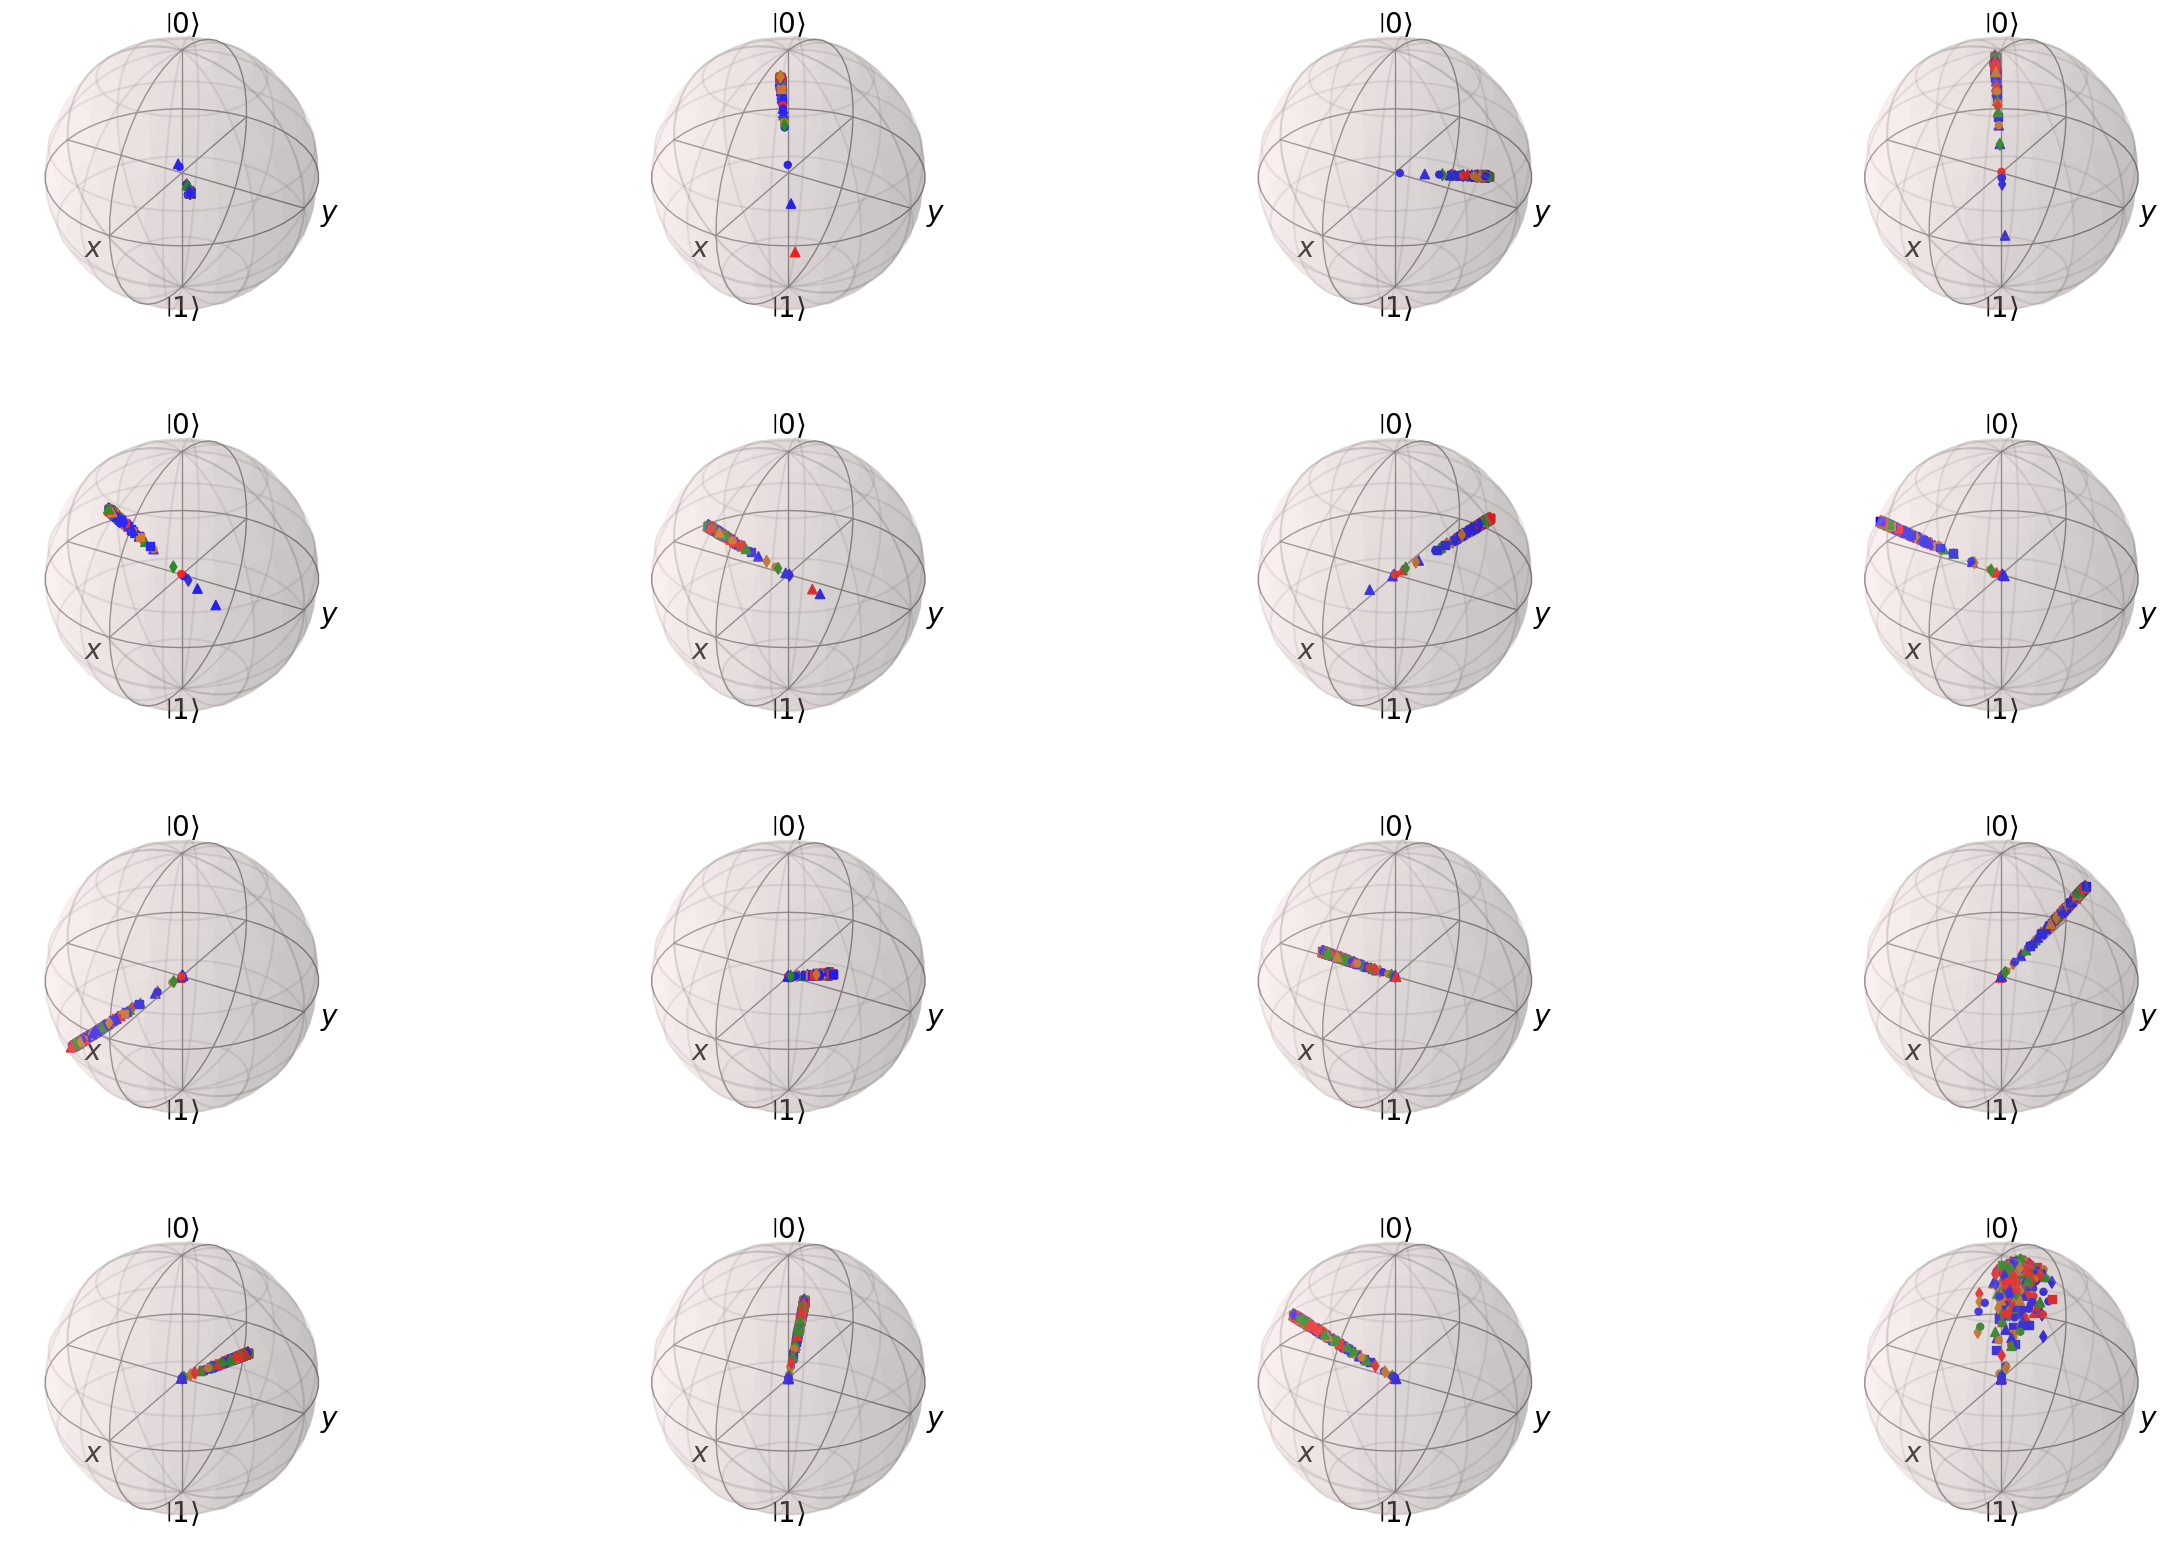

In [167]:
get_sv(graphs[split:split+100], 16)

#Models

In [ ]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        # print(layer_name);

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          nlayers=2,
                          bias=False,
                          **kwargs),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             nlayers=2,
                             bias=False,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
            (PyTorch geometric notation)
        """
        for idx, l in enumerate(self.layers):
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
                # print(f'after QGCN', x.shape)
        return x

In [ ]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.embed = nn.Linear(c_in, c_hidden)
        self.GNN = GNNModel(c_in=c_hidden,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Linear(c_hidden, c_out)
        )
        self.GCNConv =  geom_nn.GCNConv(in_channels=c_hidden,
                             out_channels=c_hidden,
                             nlayers=2,
                             bias=False,
                             **kwargs)

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
            (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
#         print('input', x.shape)
        # print(x.dtype, type(x))

        x = self.embed(x)
        # print('after embed', x.shape)
        x = self.GNN(x, edge_index) ## Node Level for quantum
        # print('after GNN', x.shape)
        # x = self.GCNConv(x, edge_index) # Hybrid quantum
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling at graph level feature
        # print('after pool', x.shape)
        x = self.head(x)
        # print('after head', x.shape)
        return x # one row per graph (transaction).

In [ ]:
def get_prob(probs):
  ex = probs.exp();
  return ex / ex.sum();

class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphGNNModel(**model_kwargs).to(device);
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.one_cycle_max_lr = 1e-1
        self.one_cycle_total_steps = 100
        self.test_prob = [];
        self.test_actual = [];

    def forward(self, tdata, mode="train"):
        data = tdata

#         n_node = tdata.x.shape[0]
#         power = 1
#         while power < n_node:
#             power *= 2
#         data = T.Pad(power, mask_pad_value=True)(tdata)

#         print(data)

        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float() # Positive means fraud
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        # print("After model", x, preds)

        target = data.y.cpu().numpy();
        predicton = preds.cpu().numpy();

        cm = confusion_matrix(target,predicton);
        ac = accuracy_score(target,predicton);
        ps = precision_score(target,predicton);
        rs = recall_score(target,predicton);
        fs = f1_score(target,predicton);

        # print("Values", cm)
        if mode == "test":
          return loss, acc, cm, ac, ps, rs, fs, target, get_prob(x).cpu().numpy();
        else :
          return loss, acc, cm, ac, ps, rs, fs;

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.001)
        return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        # print(loss)
        # print("Training called for: ", batch_idx);
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="val")
        self.log('val_acc', acc, prog_bar=True, batch_size=batch_s)
        self.log('val_loss', loss, prog_bar=True, batch_size=batch_s)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs, y, x  = self.forward(batch, mode="test")
        self.log('test_acc', acc, on_step=False, on_epoch=True, batch_size=batch_s)
        # self.log('test_cm', cm.tolist(), on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ac', ac, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ps', ps, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_rs', rs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_fs', fs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.test_prob.extend(x.tolist());
        self.test_actual.extend(y.tolist());



    # def on_test_batch_end(self, outputs, batch, batch_idx):
    #     # print(outputs, batch, batch_idx);
    #     x, edge_index, batch_idx, y = batch.x, batch.edge_index, batch.batch, batch.y
    #     x = self.model(x, edge_index, batch_idx)
    #     x = x.squeeze(dim=-1)
    #     # print(x);
    #     x = get_prob(x);
    #     # print(x);
    #     if self.test_prob == None:
    #       self.test_prob = x;
    #     else:
    #       self.test_prob = tr.cat((self.test_prob, x));
    #     if self.test_actual == None:
    #       self.test_actual = y;
    #     else:
    #       self.test_actual = tr.cat((self.test_actual, y));


# Trainer

In [ ]:
from time import time

CHECKPOINT_PATH = "/content/checkpoints"

class MetricTracker(Callback):

  def __init__(self):
    self.collection = []

  def on_train_epoch_end(self, trainer, module):
    metric = trainer.logged_metrics.copy();
    self.collection.append(metric)
    # print("train trainer end", trainer.logged_metrics)

def disp_loss(trainer):
  # print(trainer.callbacks[2].collection)

  train_loss = list(map(lambda x: x['train_loss'].item(),
                        trainer.callbacks[2].collection));
  val_loss = list(map(lambda x: x['val_loss'].item(),
                        trainer.callbacks[2].collection));

  # print(range(len(train_loss)), train_loss)
  fig = plt.figure();
  plt.plot(range(len(train_loss)), train_loss, color = 'b', label = 'Training Loss');
  plt.plot(range(len(val_loss)),val_loss, color = 'r', label = 'Validation Loss');

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # Adding legend, which helps us recognize the curve according to it's color
  plt.legend()
  plt.show();
  fig.savefig('Quantum_Loss.pdf', format='pdf', dpi=300, bbox_inches='tight');


def train_graph_classifier(model_name, num_epochs=10, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)

    callbacks = [
        ModelSummary(max_depth=4),
                 LearningRateMonitor(logging_interval='epoch'),
                 MetricTracker()
                 ]

    # logger = WandbLogger(project='qgnn-hep')
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=callbacks,
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         log_every_n_steps=2,
                        #  logger = True,
                         max_epochs=num_epochs,
                         enable_progress_bar=True)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename).to(device)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=28,
                              c_out=1 ,
                              **model_kwargs).to(device)

        s = time()
        trainer.fit(model, graph_train_loader, graph_val_loader)
        e = time()

        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    disp_loss(trainer);

    # Test best model on validation and test set
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    test_y, test_prob = model.test_actual, model.test_prob;
    train_result = trainer.test(model, graph_train_loader, verbose=False)

    result = [];
    print("Result", test_result)
    result.append({"test": test_result[0]['test_acc'],
                   "train": train_result[0]['test_acc']})
    # result.append({"test": test_result[0]['test_cm'],
    #                "train": train_result[0]['test_cm']})
    result.append({"test": test_result[0]['test_ac'],
                   "train": train_result[0]['test_ac']})
    result.append({"test": test_result[0]['test_ps'],
                   "train": train_result[0]['test_ps']})
    result.append({"test": test_result[0]['test_rs'],
                   "train": train_result[0]['test_rs']})
    result.append({"test": test_result[0]['test_fs'],
                   "train": train_result[0]['test_fs']})

    return model, result, (e-s)/num_epochs, test_y, test_prob

# Run

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                      | Type              | Params
-----------------------------------------------------------------
0  | model                     | GraphGNNModel     | 265   
1  | model.embed               | Li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


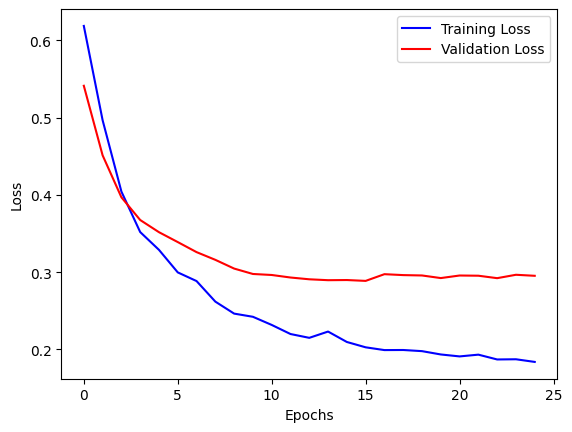

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Result [{'test_acc': 0.908203125, 'test_ac': 0.908203125, 'test_ps': 0.8872767857142858, 'test_rs': 0.7374436327561327, 'test_fs': 0.7990466233113294}]


In [ ]:
num_epochs = 25
model, result, avg_epoch_time, test_y, test_prob = train_graph_classifier(model_name="QGCN",
                                       c_hidden=6,
                                       layer_name="QGCN",
                                       num_layers=2,
                                       num_epochs=num_epochs,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)


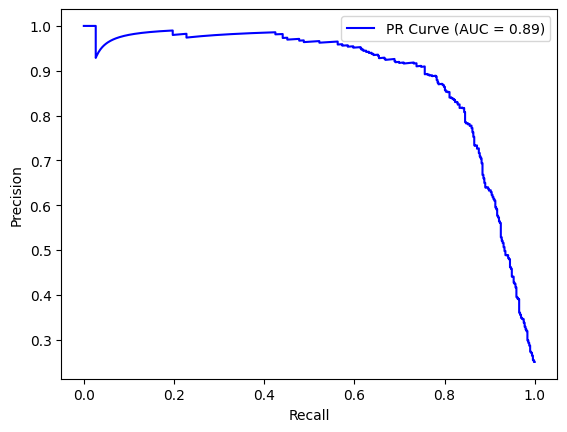

In [ ]:
# Precision - recall curve
precision, recall, thresholds = precision_recall_curve(test_y, test_prob)
auc_pr = auc(recall, precision)
fig = plt.figure();
plt.plot(recall, precision, color = 'b', label = f'PR Curve (AUC = {auc_pr:2.2f})');
plt.xlabel("Recall")
plt.ylabel("Precision")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
plt.show();
fig.savefig('Quantum_PR.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [ ]:
# # Roc Curve
# fpr, tpr, thresholds = roc_curve(y, probs)
# auc = roc_auc_score(y, probs)
# print('AUC: %.3f' % auc)


In [ ]:
print(f"Train performance accuracy: {100.0*result[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0*result[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0*result[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0*result[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0*result[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0*result[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result[4]['test']:4.2f}")


print(f"time: {avg_epoch_time*num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time}")

Train performance accuracy: 94.61%
Test performance accuracy:  90.82%
Train performance Precision: 91.47%
Test performance Precision:  88.73%
Train performance Recall: 83.09%
Test performance Recall:  73.74%
Train performance f1 Score: 0.86
Test performance f1 Score:  0.80
time: 857.1685445308684
Avg time per epoch: 34.28674178123474


# Results

25 epochs only

| num qubits  | layers | Accuracy (%) | Precision (%) | Recall (%) | F1Score|
|---|---|---|---|---|---|
| 6  | 1 | 94.5 | 96.1 | 79.5 | .86|
| 16  | 1 | 92.06 | 86.5 | 77.3 | .81
| 6  | 2 | 91.5 | 93.3 | 65.6 | .76 |
| 16  | 2 | 89.2 | 86.6 | 72 | .77 |

Hidden dimension = 6, number of layers = 1

GCN: {'test_acc': 0.91796875, 'test_ac': 0.91796875, 'test_ps': 0.9380208333333333, 'test_rs': 0.7529853826728827, 'test_fs': 0.8231823723886081}


GAT: {'test_acc': 0.923828125, 'test_ac': 0.923828125, 'test_ps': 0.9519097222222223, 'test_rs': 0.7634020493395494, 'test_fs': 0.8384800863705327}


GraphConv: {'test_acc': 0.9088541865348816, 'test_ac': 0.9088541666666666, 'test_ps': 0.8939732142857144, 'test_rs': 0.7590617715617716, 'test_fs': 0.8080692234761172}

SAGEConv: {'test_acc': 0.9186198115348816, 'test_ac': 0.9186197916666666, 'test_ps': 0.867013888888889, 'test_rs': 0.7321856962481962, 'test_fs': 0.7766455256344964}